# POC Delivery Time Prediction — Scoring Notebook

**Goal:** Load the trained model from MLflow and generate predictions for all shipments.

**Workflow:**
1. Load trained model from MLflow
2. Get shipment data using DAX (same as training)
3. Generate predictions
4. Save predictions to Lakehouse table
5. Connect to Power BI for visualization


### 🟦 1. Import Libraries 

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Model loading
import mlflow

# Semantic Link - Connect to Power BI
import sempy.fabric as fabric

# Spark for writing to Lakehouse
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

print("✅ All libraries imported")

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 5, Finished, Available, Finished)

✅ All libraries imported


### 🟦 2. Configuration

In [1]:
# Semantic model name
DATASET = "delivery semantic model"

# MLflow model details
MODEL_NAME = "POC-DeliveryTimeModel-AutoML-Safe"
MODEL_VERSION = "latest"  # or specify version like "3"

print(f"📊 Dataset: {DATASET}")
print(f"🤖 Model: {MODEL_NAME}")
print(f"📌 Version: {MODEL_VERSION}")

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 3, Finished, Available, Finished)

📊 Dataset: delivery semantic model
🤖 Model: POC-DeliveryTimeModel-AutoML-Safe
📌 Version: latest


### 🟦 3. Load the AutoML Model from MLflow

Loads the AutoML model exactly as it was trained, with preprocessing and encoders baked in.
Since AutoML-Safe saves model.model as the underlying estimator, we load that.

In [4]:
# Construct model URI
model_uri = f"models:/{MODEL_NAME}/{MODEL_VERSION}"

# Load model
model = mlflow.sklearn.load_model(model_uri)

print(f"✅ Loaded model: {type(model).__name__}")
print(f"📍 From: {model_uri}")

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 6, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


✅ Loaded model: RandomForestEstimator
📍 From: models:/POC-DeliveryTimeModel-AutoML-Safe/latest


StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 7, Finished, Available, Finished)

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 17, Finished, Available, Finished)

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 18, Finished, Available, Finished)

### 🟦 4. Load Semantic Model Tables

**Same approach as training notebook!**
- Use DAX with RELATED() to get enriched data
- Leverages Power BI relationships
- No manual joins needed

In [5]:
# Same DAX query as notebook 02
dax_query = """
EVALUATE
ADDCOLUMNS(
    shipments,
    "carrier_name", RELATED(carriers[carrier_name]),
    "carrier_speed_factor", RELATED(carriers[speed_factor]),
    "warehouse_name", RELATED(warehouses[warehouse_name])
)
"""

# Execute DAX query
df = fabric.evaluate_dax(dataset=DATASET, dax_string=dax_query)

# Clean column names (remove table prefixes)
df.columns = [col.split('[')[-1].replace(']', '') for col in df.columns]

print(f"✅ Loaded {len(df):,} shipments for scoring")
print(f"✅ Columns: {df.shape[1]}")
df.head()

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 8, Finished, Available, Finished)

✅ Loaded 5,000 shipments for scoring
✅ Columns: 17


,order_to_ship_days,ship_dayofweek,ship_month,distance_band,service_level,order_date,ship_date,delivery_date,delivery_days_actual,shipment_id,carrier_id,warehouse_id,origin_region,destination_region,carrier_name,carrier_speed_factor,warehouse_name
0,2.378452,4,1,Medium,Ground,2024-01-17,2024-01-19 09:04:58.270000,2024-01-22 23:32:23.310000,3.602373,4376,3,2,Midwest,Northeast,SlowShip,1.3,Midwest DC
1,0.807782,1,2,Medium,Fast,2024-02-06,2024-02-06 19:23:12.383333,2024-02-08 02:10:40.393333,1.282963,4377,2,2,Midwest,West,StandardShip,1.0,Midwest DC
2,1.466133,0,2,Long,Ground,2024-02-18,2024-02-19 11:11:13.903333,2024-02-22 22:03:14.166667,3.452781,4378,1,3,South,Midwest,FastShip,0.7,South DC
3,1.56197,4,5,Medium,Fast,2024-05-16,2024-05-17 13:29:14.173333,2024-05-18 19:40:26.240000,1.257779,4379,2,1,West,Midwest,StandardShip,1.0,West DC
4,0.643652,2,6,Long,Ground,2024-06-26,2024-06-26 15:26:51.523333,2024-07-02 02:53:50.863333,5.477076,4380,2,2,Midwest,Northeast,StandardShip,1.0,Midwest DC


### 🟦 5. Prepare Features

Extract the same features used during training.

In [6]:
# Same features as training
feature_cols = [
    "carrier_id",
    "warehouse_id",
    "origin_region",
    "destination_region",
    "distance_band",
    "service_level",
    "order_to_ship_days",
    "ship_dayofweek",
    "ship_month",
]

# Extract features
X_score = df[feature_cols].copy()

# Encode categorical variables (same as training)
categorical_cols = ['origin_region', 'destination_region', 'distance_band', 'service_level']
for col in categorical_cols:
    X_score[col] = X_score[col].astype("category").cat.codes

print(f"✅ Prepared {len(X_score):,} rows for scoring")
print(f"✅ Features: {X_score.shape[1]} columns")


StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 9, Finished, Available, Finished)

✅ Prepared 5,000 rows for scoring
✅ Features: 9 columns


### 🟦 6. Generate Predictions

In [7]:
# Generate predictions
predictions = model.predict(X_score)

# Add predictions to dataframe
df["predicted_delivery_days"] = predictions

print(f"✅ Generated {len(predictions):,} predictions")
print(f"\n📊 Prediction Statistics:")
print(f"   Mean: {predictions.mean():.2f} days")
print(f"   Median: {np.median(predictions):.2f} days")
print(f"   Min: {predictions.min():.2f} days")
print(f"   Max: {predictions.max():.2f} days")

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 10, Finished, Available, Finished)

✅ Generated 5,000 predictions

📊 Prediction Statistics:
   Mean: 2.54 days
   Median: 2.07 days
   Min: 0.82 days
   Max: 6.51 days


### 🟦 7. Preview Predictions

In [8]:
# Show sample predictions with context
preview_cols = [
    'shipment_id',
    'carrier_name',
    'service_level',
    'distance_band',
    'predicted_delivery_days',
    'delivery_days_actual'  # if available for comparison
]

# Select available columns
available_cols = [col for col in preview_cols if col in df.columns]

print("Sample predictions:")
print(df[available_cols].head(10))

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 11, Finished, Available, Finished)

Sample predictions:
   shipment_id  carrier_name service_level distance_band  \
0         4376      SlowShip        Ground        Medium   
1         4377  StandardShip          Fast        Medium   
2         4378      FastShip        Ground          Long   
3         4379  StandardShip          Fast        Medium   
4         4380  StandardShip        Ground          Long   
5         4381      SlowShip        Ground        Medium   
6         4382      SlowShip        Ground          Long   
7         4383      FastShip        Ground        Medium   
8         4384  StandardShip        Ground        Medium   
9         4385      FastShip        Ground        Medium   

   predicted_delivery_days  delivery_days_actual  
0                 3.872579              3.602373  
1                 1.508308              1.282963  
2                 3.587403              3.452781  
3                 1.508308              1.257779  
4                 4.998352              5.477076  
5            

### 🟦 8. Save Predictions to Lakehouse

Write predictions to a table that Power BI can access.

In [10]:
# Select columns for output
output_cols = [
    'shipment_id',
    'predicted_delivery_days',
    'service_level',
    'carrier_name',
    'warehouse_name',
    'distance_band',
    'order_date',
    'ship_date'
]

# Create output dataframe with available columns
output_df = df[[col for col in output_cols if col in df.columns]].copy()

# Add metadata
output_df['prediction_date'] = pd.Timestamp.now()
output_df['model_version'] = MODEL_VERSION

# Convert to Spark DataFrame
predictions_spark = spark.createDataFrame(output_df)

# Write to Lakehouse with schema overwrite
predictions_spark.write \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("shipment_predictions")

print("="*60)
print("✅ PREDICTIONS SAVED TO LAKEHOUSE")
print("="*60)
print(f"Table: shipment_predictions")
print(f"Rows: {len(output_df):,}")
print(f"Columns: {list(output_df.columns)}")
print("="*60)

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 13, Finished, Available, Finished)

✅ PREDICTIONS SAVED TO LAKEHOUSE
Table: shipment_predictions
Rows: 5,000
Columns: ['shipment_id', 'predicted_delivery_days', 'service_level', 'carrier_name', 'warehouse_name', 'distance_band', 'order_date', 'ship_date', 'prediction_date', 'model_version']


# Visualizing the predictions

## 9️⃣ Scoring Summary

In [11]:
print("\n" + "="*70)
print("                   BATCH SCORING COMPLETE")
print("="*70)

print(f"\n📊 DATA SOURCE")
print(f"   Method: Semantic Link + DAX")
print(f"   Query: Same as training (RELATED())")
print(f"   Rows scored: {len(df):,}")

print(f"\n🤖 MODEL")
print(f"   Name: {MODEL_NAME}")
print(f"   Version: {MODEL_VERSION}")
print(f"   Type: {type(model).__name__}")

print(f"\n📈 PREDICTIONS")
print(f"   Average: {predictions.mean():.2f} days")
print(f"   Median: {np.median(predictions):.2f} days")
print(f"   Range: {predictions.min():.2f} - {predictions.max():.2f} days")

print(f"\n💾 OUTPUT")
print(f"   Table: shipment_predictions")
print(f"   Location: Lakehouse")
print(f"   Columns: {len(output_df.columns)}")

print(f"\n🎯 NEXT STEPS")
print(f"   → Open Power BI Desktop")
print(f"   → Connect to '{DATASET}'")
print(f"   → Use 'shipment_predictions' table")
print(f"   → Build dashboards to visualize predictions")

print("="*70 + "\n")

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 14, Finished, Available, Finished)


                   BATCH SCORING COMPLETE

📊 DATA SOURCE
   Method: Semantic Link + DAX
   Query: Same as training (RELATED())
   Rows scored: 5,000

🤖 MODEL
   Name: POC-DeliveryTimeModel-AutoML-Safe
   Version: latest
   Type: RandomForestEstimator

📈 PREDICTIONS
   Average: 2.54 days
   Median: 2.07 days
   Range: 0.82 - 6.51 days

💾 OUTPUT
   Table: shipment_predictions
   Location: Lakehouse
   Columns: 10

🎯 NEXT STEPS
   → Open Power BI Desktop
   → Connect to 'delivery semantic model'
   → Use 'shipment_predictions' table
   → Build dashboards to visualize predictions



### Prediction Distribution Visualization

What it shows:

- X-axis: Predicted delivery days (e.g., 1, 2, 3, 4, 5 days)
- Y-axis: How many shipments fall into each delivery time bucket
- Red dashed line: The average predicted delivery time

What you learn:

- Shape of distribution: Is it bell-curved (normal)? Skewed right (many long deliveries)? Bimodal (two peaks)?
- Concentration: Are most predictions clustered around a specific value?
- Range: What's the spread from fastest to slowest predicted deliveries?

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 15, Finished, Available, Finished)

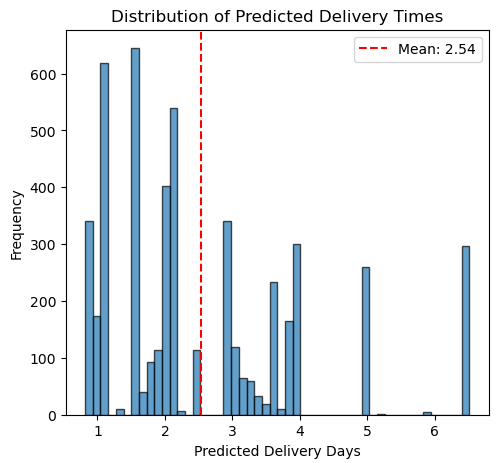

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

### 🟦 7.6. Visualize Prediction Distribution

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df['predicted_delivery_days'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Delivery Days')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Delivery Times')
plt.axvline(df['predicted_delivery_days'].mean(), color='r', linestyle='--', 
            label=f'Mean: {df["predicted_delivery_days"].mean():.2f}')
plt.legend()

### Box Plot by Service Level 

What it shows:

- X-axis: Service level categories (Standard, Express, Overnight)
- Y-axis: Predicted delivery days
- Box: 50% of predictions fall within this range
- Line in box: Median (middle value)
- Whiskers: Min/max (excluding outliers)
- Dots: Outliers

What you learn:

- Service level differences: Does Express actually predict faster deliveries than Standard?
- Variability: Which service level has most consistent predictions? (narrower box = more consistent)
- Outliers: Which service level has unusual predictions?

StatementMeta(, 0425cf0b-0c96-4a31-bdb7-05a3d141c015, 16, Finished, Available, Finished)

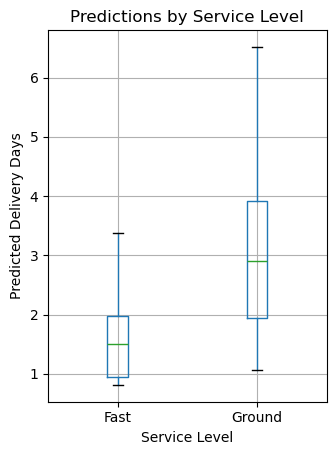

In [13]:
# Box plot by service level
plt.subplot(1, 2, 2)
df.boxplot(column='predicted_delivery_days', by='service_level', ax=plt.gca())
plt.suptitle('')
plt.title('Predictions by Service Level')
plt.xlabel('Service Level')
plt.ylabel('Predicted Delivery Days')

plt.tight_layout()
plt.show()

# So, what's next?

 ## Next Steps: Visualize Predictions in Power BI

### ✅ Predictions Ready
- **Table**: `shipment_predictions`
- **Location**: Fabric Lakehouse
- **Rows**: Generated from scoring pipeline
- **Columns**: shipment_id, predicted_delivery_days, service_level, carrier_name, distance, etc.

---

###  Connect Power BI to Predictions

#### Step 1: Open Power BI Desktop
1. Launch **Power BI Desktop**
2. Click **Get Data** → **More**

#### Step 2: Connect to Semantic Model
1. Search for **"Power BI datasets"** or **"Power Platform"**
2. Select **Power BI semantic models**
3. Choose your Fabric workspace
4. Select **"delivery semantic model"**
5. Click **Connect**

#### Step 3: Load Predictions Table
1. In the Navigator, check the box next to **`shipment_predictions`**
2. Optionally, also select:
   - `shipments` (for actuals comparison)
   - `carriers` (for carrier details)
   - `warehouses` (for warehouse analysis)
3. Click **Load**

---

### 📈 Recommended Visualizations

#### Page 1: Executive Overview

**KPI Cards:**
- Average Predicted Delivery Days
- Total Shipments Scored
- Max Predicted Delivery Time
- Model Version Used

**Line Chart:**
- X-axis: `shipment_date`
- Y-axis: `predicted_delivery_days` (average)
- Legend: `service_level`

**Table:**
- Columns: `shipment_id`, `carrier_name`, `service_level`, `predicted_delivery_days`, `distance`

#### Page 2: Carrier Performance

**Bar Chart:**
- X-axis: `carrier_name`
- Y-axis: `predicted_delivery_days` (average)
- Sort: By average descending

**Scatter Plot:**
- X-axis: `distance`
- Y-axis: `predicted_delivery_days`
- Legend: `carrier_name`

#### Page 3: Service Level Analysis

**Clustered Column Chart:**
- X-axis: `service_level`
- Y-axis: Count of shipments, Average predicted days
- Show: Side-by-side comparison

**Box & Whisker Plot** (if available):
- Category: `service_level`
- Values: `predicted_delivery_days`

---

### 🔗 Optional: Compare Predictions vs Actuals

If you want to track model accuracy over time:

#### Create Relationship
1. Go to **Model View** in Power BI
2. Create relationship between:
   - `shipment_predictions[shipment_id]` ← → `shipments[shipment_id]`
3. Relationship type: **Many-to-One**

#### Create DAX Measures

**Prediction Error:**
```dax
Prediction Error = 
AVERAGE(shipments[actual_delivery_days]) - AVERAGE(shipment_predictions[predicted_delivery_days])
